In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
torch.__version__

'2.0.1'

In [2]:
torch.manual_seed(123)

In [3]:
#CONSTRUINDO O MODELO DA REDE NEURAL
#output = (input - filter +1) / stride 
# convolucao 2d em 3 canais(RGB) com 32 filtros(como gradiente, suavizacao, sepia...), kernel_size = matriz de multiplicacao
classificador = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                              #ReLU = funcao de ativacao, zerando os valores negativos e fixando os valores positivos na matriz
                              nn.ReLU(),
                              #normalizacao para acelerar o processo de convergencia em 32 mapa de caracteristicas(out_channels)
                              #(64-3+1)/1 = 62x62
                              nn.BatchNorm2d(num_features=32),
                              #a partir do mapa de caracteristicas, gerar uma nova matriz com o kernel 2x2
                              #31x31 = 62/2
                              nn.MaxPool2d(kernel_size=2),
                              #32 filtros, 32 mapa de caracteristicas, kernel (3x3)
                              nn.Conv2d(32,32,3),
                              nn.ReLU(),
                              #(31-3+1)/1 = 29x29
                              nn.BatchNorm2d(32),
                              #kernel 2x2
                              nn.MaxPool2d(2),
                              #14x14 = 29/2 - 1
                              #conversao de matriz para vetor
                              #6272 -> 128 -> 128 -> 1
                              nn.Flatten(),
                              #construcao da rede neural com 6.272 neuronios de entrada conectados a 128 neuronios na primeira camada
                              #14 linhas * 14 colunas * 32(numero de filtros)
                              nn.Linear(in_features=14*14*32, out_features=128),
                              nn.ReLU(),
                              #ignorando 2% dos neuronios gerados nas camadas (outliers)
                              nn.Dropout(0.2),
                              #ligacao da segunda camada 
                              nn.Linear(128,128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              #ligacao da terceira camada, retornando apenas 1 valor definindo se e gato ou cachorro (classificacao binaria)
                              nn.Linear(128,1),
                              #retorno do resultado da classificacao binaria
                              nn.Sigmoid())

In [4]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

In [5]:
data_dir_train = './training_set/'
data_dir_test = './test_set/'

In [6]:
#redimensionamento das imagens de treino e test antes do processamento
transform_train = transforms.Compose(
[
    transforms.Resize([64,64]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=7, translate=(0,0.07), shear=0.2, scale=(1,1.2)),
    transforms.ToTensor()
])

In [7]:
transform_test = transforms.Compose(
[
    transforms.Resize([64,64]),
    transforms.ToTensor()
])

In [8]:
#conjunto de dados de treino / capturando as imagens e aplicando as transformacoes para o treino
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: ./training_set/
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [10]:
#criacao do pacote de treino / conteudo do arquivo ja tratado com o redimensionamento, com lotes de 32 imagens comunicando-se entre si para formar
#um pacote de informacoes a serem tratadas
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
#conjunto de dados de teste / fazendo o mesmo para as imagens de teste
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test)

In [12]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 2142
    Root location: ./test_set/
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [13]:
#criacao do pacote de teste
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [15]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [16]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
        
        #imprimindo os dados referentes a esse loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i+1, len(loader), loss, accuracy))
        
        #imprimindo os dados referentes a essa época
        print('\rÉpoca {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), 
                                                                              running_accuracy/len(loader)
                                                                              ))
        
        

In [17]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    classificador.train()

Treinando...
Época   1 - Loop   1 de 250: perda 0.70 - precisão 0.50
Época   1 FINALIZADA: perda 0.00280 - precisão 0.00200
Época   1 - Loop   2 de 250: perda 0.75 - precisão 0.50
Época   1 FINALIZADA: perda 0.00581 - precisão 0.00400
Época   1 - Loop   3 de 250: perda 0.80 - precisão 0.50
Época   1 FINALIZADA: perda 0.00901 - precisão 0.00600
Época   1 - Loop   4 de 250: perda 0.70 - precisão 0.44
Época   1 FINALIZADA: perda 0.01182 - precisão 0.00775
Época   1 - Loop   5 de 250: perda 0.72 - precisão 0.38
Época   1 FINALIZADA: perda 0.01472 - precisão 0.00925
Época   1 - Loop   6 de 250: perda 0.72 - precisão 0.50
Época   1 FINALIZADA: perda 0.01758 - precisão 0.01125
Época   1 - Loop   7 de 250: perda 0.76 - precisão 0.44
Época   1 FINALIZADA: perda 0.02061 - precisão 0.01300
Época   1 - Loop   8 de 250: perda 0.72 - precisão 0.56
Época   1 FINALIZADA: perda 0.02347 - precisão 0.01525
Época   1 - Loop   9 de 250: perda 0.68 - precisão 0.47
Época   1 FINALIZADA: perda 0.02619 - preci

Época   1 - Loop  75 de 250: perda 0.64 - precisão 0.62
Época   1 FINALIZADA: perda 0.20310 - precisão 0.17838
Época   1 - Loop  76 de 250: perda 0.64 - precisão 0.56
Época   1 FINALIZADA: perda 0.20568 - precisão 0.18063
Época   1 - Loop  77 de 250: perda 0.64 - precisão 0.56
Época   1 FINALIZADA: perda 0.20823 - precisão 0.18288
Época   1 - Loop  78 de 250: perda 0.59 - precisão 0.75
Época   1 FINALIZADA: perda 0.21059 - precisão 0.18588
Época   1 - Loop  79 de 250: perda 0.61 - precisão 0.66
Época   1 FINALIZADA: perda 0.21304 - precisão 0.18850
Época   1 - Loop  80 de 250: perda 0.76 - precisão 0.56
Época   1 FINALIZADA: perda 0.21606 - precisão 0.19075
Época   1 - Loop  81 de 250: perda 0.73 - precisão 0.56
Época   1 FINALIZADA: perda 0.21898 - precisão 0.19300
Época   1 - Loop  82 de 250: perda 0.63 - precisão 0.72
Época   1 FINALIZADA: perda 0.22152 - precisão 0.19588
Época   1 - Loop  83 de 250: perda 0.55 - precisão 0.75
Época   1 FINALIZADA: perda 0.22372 - precisão 0.19888
É

Época   1 - Loop 149 de 250: perda 0.56 - precisão 0.66
Época   1 FINALIZADA: perda 0.39109 - precisão 0.37050
Época   1 - Loop 150 de 250: perda 0.64 - precisão 0.69
Época   1 FINALIZADA: perda 0.39365 - precisão 0.37325
Época   1 - Loop 151 de 250: perda 0.69 - precisão 0.66
Época   1 FINALIZADA: perda 0.39641 - precisão 0.37588
Época   1 - Loop 152 de 250: perda 0.56 - precisão 0.78
Época   1 FINALIZADA: perda 0.39867 - precisão 0.37900
Época   1 - Loop 153 de 250: perda 0.56 - precisão 0.72
Época   1 FINALIZADA: perda 0.40090 - precisão 0.38188
Época   1 - Loop 154 de 250: perda 0.48 - precisão 0.78
Época   1 FINALIZADA: perda 0.40283 - precisão 0.38500
Época   1 - Loop 155 de 250: perda 0.68 - precisão 0.69
Época   1 FINALIZADA: perda 0.40553 - precisão 0.38775
Época   1 - Loop 156 de 250: perda 0.83 - precisão 0.47
Época   1 FINALIZADA: perda 0.40885 - precisão 0.38963
Época   1 - Loop 157 de 250: perda 0.61 - precisão 0.69
Época   1 FINALIZADA: perda 0.41130 - precisão 0.39238
É

Época   1 - Loop 224 de 250: perda 0.69 - precisão 0.59
Época   1 FINALIZADA: perda 0.57298 - precisão 0.57237
Época   1 - Loop 225 de 250: perda 0.59 - precisão 0.72
Época   1 FINALIZADA: perda 0.57535 - precisão 0.57525
Época   1 - Loop 226 de 250: perda 0.70 - precisão 0.56
Época   1 FINALIZADA: perda 0.57815 - precisão 0.57750
Época   1 - Loop 227 de 250: perda 0.71 - precisão 0.72
Época   1 FINALIZADA: perda 0.58100 - precisão 0.58038
Época   1 - Loop 228 de 250: perda 0.65 - precisão 0.56
Época   1 FINALIZADA: perda 0.58359 - precisão 0.58263
Época   1 - Loop 229 de 250: perda 0.60 - precisão 0.62
Época   1 FINALIZADA: perda 0.58598 - precisão 0.58513
Época   1 - Loop 230 de 250: perda 0.62 - precisão 0.66
Época   1 FINALIZADA: perda 0.58847 - precisão 0.58775
Época   1 - Loop 231 de 250: perda 0.58 - precisão 0.72
Época   1 FINALIZADA: perda 0.59080 - precisão 0.59063
Época   1 - Loop 232 de 250: perda 0.54 - precisão 0.78
Época   1 FINALIZADA: perda 0.59295 - precisão 0.59375
É

Época   1 - Loop  48 de  67: perda 0.64 - precisão 0.66
Época   1 FINALIZADA: perda 0.43831 - precisão 0.44170
Época   1 - Loop  49 de  67: perda 0.70 - precisão 0.53
Época   1 FINALIZADA: perda 0.44881 - precisão 0.44963
Época   1 - Loop  50 de  67: perda 0.66 - precisão 0.62
Época   1 FINALIZADA: perda 0.45871 - precisão 0.45896
Época   1 - Loop  51 de  67: perda 0.51 - precisão 0.78
Época   1 FINALIZADA: perda 0.46634 - precisão 0.47062
Época   1 - Loop  52 de  67: perda 0.63 - precisão 0.59
Época   1 FINALIZADA: perda 0.47573 - precisão 0.47948
Época   1 - Loop  53 de  67: perda 0.48 - precisão 0.78
Época   1 FINALIZADA: perda 0.48297 - precisão 0.49114
Época   1 - Loop  54 de  67: perda 0.52 - precisão 0.72
Época   1 FINALIZADA: perda 0.49080 - precisão 0.50187
Época   1 - Loop  55 de  67: perda 0.40 - precisão 0.66
Época   1 FINALIZADA: perda 0.49678 - precisão 0.51166
Época   1 - Loop  56 de  67: perda 0.60 - precisão 0.50
Época   1 FINALIZADA: perda 0.50572 - precisão 0.51912
É

Época   2 - Loop  56 de 250: perda 0.42 - precisão 0.75
Época   2 FINALIZADA: perda 0.12943 - precisão 0.15500
Época   2 - Loop  57 de 250: perda 0.72 - precisão 0.62
Época   2 FINALIZADA: perda 0.13231 - precisão 0.15750
Época   2 - Loop  58 de 250: perda 0.62 - precisão 0.62
Época   2 FINALIZADA: perda 0.13480 - precisão 0.16000
Época   2 - Loop  59 de 250: perda 0.61 - precisão 0.66
Época   2 FINALIZADA: perda 0.13723 - precisão 0.16263
Época   2 - Loop  60 de 250: perda 0.55 - precisão 0.69
Época   2 FINALIZADA: perda 0.13942 - precisão 0.16538
Época   2 - Loop  61 de 250: perda 0.48 - precisão 0.78
Época   2 FINALIZADA: perda 0.14135 - precisão 0.16850
Época   2 - Loop  62 de 250: perda 0.41 - precisão 0.91
Época   2 FINALIZADA: perda 0.14297 - precisão 0.17213
Época   2 - Loop  63 de 250: perda 0.54 - precisão 0.72
Época   2 FINALIZADA: perda 0.14515 - precisão 0.17500
Época   2 - Loop  64 de 250: perda 0.64 - precisão 0.59
Época   2 FINALIZADA: perda 0.14771 - precisão 0.17738
É

Época   2 - Loop 130 de 250: perda 0.54 - precisão 0.69
Época   2 FINALIZADA: perda 0.29567 - precisão 0.36650
Época   2 - Loop 131 de 250: perda 0.56 - precisão 0.62
Época   2 FINALIZADA: perda 0.29792 - precisão 0.36900
Época   2 - Loop 132 de 250: perda 0.61 - precisão 0.69
Época   2 FINALIZADA: perda 0.30036 - precisão 0.37175
Época   2 - Loop 133 de 250: perda 0.49 - precisão 0.78
Época   2 FINALIZADA: perda 0.30230 - precisão 0.37488
Época   2 - Loop 134 de 250: perda 0.54 - precisão 0.69
Época   2 FINALIZADA: perda 0.30445 - precisão 0.37763
Época   2 - Loop 135 de 250: perda 0.44 - precisão 0.72
Época   2 FINALIZADA: perda 0.30621 - precisão 0.38050
Época   2 - Loop 136 de 250: perda 0.55 - precisão 0.69
Época   2 FINALIZADA: perda 0.30840 - precisão 0.38325
Época   2 - Loop 137 de 250: perda 0.56 - precisão 0.75
Época   2 FINALIZADA: perda 0.31062 - precisão 0.38625
Época   2 - Loop 138 de 250: perda 0.63 - precisão 0.62
Época   2 FINALIZADA: perda 0.31316 - precisão 0.38875
É

Época   2 - Loop 204 de 250: perda 0.40 - precisão 0.84
Época   2 FINALIZADA: perda 0.46179 - precisão 0.57363
Época   2 - Loop 205 de 250: perda 0.57 - precisão 0.62
Época   2 FINALIZADA: perda 0.46407 - precisão 0.57613
Época   2 - Loop 206 de 250: perda 0.57 - precisão 0.69
Época   2 FINALIZADA: perda 0.46634 - precisão 0.57888
Época   2 - Loop 207 de 250: perda 0.53 - precisão 0.75
Época   2 FINALIZADA: perda 0.46847 - precisão 0.58188
Época   2 - Loop 208 de 250: perda 0.62 - precisão 0.62
Época   2 FINALIZADA: perda 0.47094 - precisão 0.58438
Época   2 - Loop 209 de 250: perda 0.47 - precisão 0.81
Época   2 FINALIZADA: perda 0.47283 - precisão 0.58763
Época   2 - Loop 210 de 250: perda 0.63 - precisão 0.66
Época   2 FINALIZADA: perda 0.47533 - precisão 0.59025
Época   2 - Loop 211 de 250: perda 0.63 - precisão 0.56
Época   2 FINALIZADA: perda 0.47787 - precisão 0.59250
Época   2 - Loop 212 de 250: perda 0.34 - precisão 0.88
Época   2 FINALIZADA: perda 0.47921 - precisão 0.59600
É

Época   2 - Loop  29 de  67: perda 0.56 - precisão 0.78
Época   2 FINALIZADA: perda 0.24314 - precisão 0.28545
Época   2 - Loop  30 de  67: perda 0.50 - precisão 0.81
Época   2 FINALIZADA: perda 0.25060 - precisão 0.29757
Época   2 - Loop  31 de  67: perda 0.44 - precisão 0.69
Época   2 FINALIZADA: perda 0.25712 - precisão 0.30784
Época   2 - Loop  32 de  67: perda 0.66 - precisão 0.53
Época   2 FINALIZADA: perda 0.26691 - precisão 0.31576
Época   2 - Loop  33 de  67: perda 0.28 - precisão 0.59
Época   2 FINALIZADA: perda 0.27110 - precisão 0.32463
Época   2 - Loop  34 de  67: perda 0.67 - precisão 0.56
Época   2 FINALIZADA: perda 0.28116 - precisão 0.33302
Época   2 - Loop  35 de  67: perda 0.45 - precisão 0.47
Época   2 FINALIZADA: perda 0.28793 - precisão 0.34002
Época   2 - Loop  36 de  67: perda 0.72 - precisão 0.47
Época   2 FINALIZADA: perda 0.29864 - precisão 0.34701
Época   2 - Loop  37 de  67: perda 0.56 - precisão 0.66
Época   2 FINALIZADA: perda 0.30694 - precisão 0.35681
É

Época   3 - Loop  38 de 250: perda 0.53 - precisão 0.78
Época   3 FINALIZADA: perda 0.08212 - precisão 0.11025
Época   3 - Loop  39 de 250: perda 0.57 - precisão 0.75
Época   3 FINALIZADA: perda 0.08438 - precisão 0.11325
Época   3 - Loop  40 de 250: perda 0.36 - precisão 0.81
Época   3 FINALIZADA: perda 0.08582 - precisão 0.11650
Época   3 - Loop  41 de 250: perda 0.61 - precisão 0.78
Época   3 FINALIZADA: perda 0.08828 - precisão 0.11963
Época   3 - Loop  42 de 250: perda 0.45 - precisão 0.84
Época   3 FINALIZADA: perda 0.09007 - precisão 0.12300
Época   3 - Loop  43 de 250: perda 0.38 - precisão 0.84
Época   3 FINALIZADA: perda 0.09161 - precisão 0.12638
Época   3 - Loop  44 de 250: perda 0.47 - precisão 0.78
Época   3 FINALIZADA: perda 0.09347 - precisão 0.12950
Época   3 - Loop  45 de 250: perda 0.50 - precisão 0.69
Época   3 FINALIZADA: perda 0.09549 - precisão 0.13225
Época   3 - Loop  46 de 250: perda 0.52 - precisão 0.69
Época   3 FINALIZADA: perda 0.09756 - precisão 0.13500
É

Época   3 - Loop 113 de 250: perda 0.62 - precisão 0.66
Época   3 FINALIZADA: perda 0.24019 - precisão 0.32888
Época   3 - Loop 114 de 250: perda 0.69 - precisão 0.59
Época   3 FINALIZADA: perda 0.24294 - precisão 0.33125
Época   3 - Loop 115 de 250: perda 0.65 - precisão 0.62
Época   3 FINALIZADA: perda 0.24553 - precisão 0.33375
Época   3 - Loop 116 de 250: perda 0.39 - precisão 0.78
Época   3 FINALIZADA: perda 0.24709 - precisão 0.33688
Época   3 - Loop 117 de 250: perda 0.42 - precisão 0.72
Época   3 FINALIZADA: perda 0.24877 - precisão 0.33975
Época   3 - Loop 118 de 250: perda 0.55 - precisão 0.78
Época   3 FINALIZADA: perda 0.25096 - precisão 0.34288
Época   3 - Loop 119 de 250: perda 0.56 - precisão 0.72
Época   3 FINALIZADA: perda 0.25320 - precisão 0.34575
Época   3 - Loop 120 de 250: perda 0.33 - precisão 0.91
Época   3 FINALIZADA: perda 0.25450 - precisão 0.34938
Época   3 - Loop 121 de 250: perda 0.38 - precisão 0.88
Época   3 FINALIZADA: perda 0.25601 - precisão 0.35288
É

Época   3 - Loop 188 de 250: perda 0.43 - precisão 0.81
Época   3 FINALIZADA: perda 0.39803 - precisão 0.55088
Época   3 - Loop 189 de 250: perda 0.42 - precisão 0.78
Época   3 FINALIZADA: perda 0.39972 - precisão 0.55400
Época   3 - Loop 190 de 250: perda 0.53 - precisão 0.75
Época   3 FINALIZADA: perda 0.40184 - precisão 0.55700
Época   3 - Loop 191 de 250: perda 0.66 - precisão 0.59
Época   3 FINALIZADA: perda 0.40449 - precisão 0.55938
Época   3 - Loop 192 de 250: perda 0.50 - precisão 0.75
Época   3 FINALIZADA: perda 0.40648 - precisão 0.56238
Época   3 - Loop 193 de 250: perda 0.40 - precisão 0.91
Época   3 FINALIZADA: perda 0.40807 - precisão 0.56600
Época   3 - Loop 194 de 250: perda 0.69 - precisão 0.69
Época   3 FINALIZADA: perda 0.41082 - precisão 0.56875
Época   3 - Loop 195 de 250: perda 0.43 - precisão 0.81
Época   3 FINALIZADA: perda 0.41254 - precisão 0.57200
Época   3 - Loop 196 de 250: perda 0.61 - precisão 0.75
Época   3 FINALIZADA: perda 0.41499 - precisão 0.57500
É

Época   3 - Loop  12 de  67: perda 0.45 - precisão 0.56
Época   3 FINALIZADA: perda 0.08852 - precisão 0.12360
Época   3 - Loop  13 de  67: perda 0.15 - precisão 0.62
Época   3 FINALIZADA: perda 0.09077 - precisão 0.13293
Época   3 - Loop  14 de  67: perda 0.58 - precisão 0.66
Época   3 FINALIZADA: perda 0.09950 - precisão 0.14272
Época   3 - Loop  15 de  67: perda 0.30 - precisão 0.69
Época   3 FINALIZADA: perda 0.10401 - precisão 0.15299
Época   3 - Loop  16 de  67: perda 0.34 - precisão 0.84
Época   3 FINALIZADA: perda 0.10910 - precisão 0.16558
Época   3 - Loop  17 de  67: perda 0.45 - precisão 0.78
Época   3 FINALIZADA: perda 0.11586 - precisão 0.17724
Época   3 - Loop  18 de  67: perda 0.46 - precisão 0.62
Época   3 FINALIZADA: perda 0.12276 - precisão 0.18657
Época   3 - Loop  19 de  67: perda 0.59 - precisão 0.66
Época   3 FINALIZADA: perda 0.13151 - precisão 0.19636
Época   3 - Loop  20 de  67: perda 0.42 - precisão 0.72
Época   3 FINALIZADA: perda 0.13776 - precisão 0.20709
É

Época   4 - Loop  19 de 250: perda 0.46 - precisão 0.78
Época   4 FINALIZADA: perda 0.03816 - precisão 0.05625
Época   4 - Loop  20 de 250: perda 0.86 - precisão 0.59
Época   4 FINALIZADA: perda 0.04159 - precisão 0.05863
Época   4 - Loop  21 de 250: perda 0.67 - precisão 0.66
Época   4 FINALIZADA: perda 0.04425 - precisão 0.06125
Época   4 - Loop  22 de 250: perda 0.62 - precisão 0.62
Época   4 FINALIZADA: perda 0.04674 - precisão 0.06375
Época   4 - Loop  23 de 250: perda 0.49 - precisão 0.81
Época   4 FINALIZADA: perda 0.04871 - precisão 0.06700
Época   4 - Loop  24 de 250: perda 0.51 - precisão 0.75
Época   4 FINALIZADA: perda 0.05074 - precisão 0.07000
Época   4 - Loop  25 de 250: perda 0.51 - precisão 0.78
Época   4 FINALIZADA: perda 0.05280 - precisão 0.07313
Época   4 - Loop  26 de 250: perda 0.66 - precisão 0.62
Época   4 FINALIZADA: perda 0.05543 - precisão 0.07563
Época   4 - Loop  27 de 250: perda 0.52 - precisão 0.66
Época   4 FINALIZADA: perda 0.05753 - precisão 0.07825
É

Época   4 - Loop  93 de 250: perda 0.60 - precisão 0.69
Época   4 FINALIZADA: perda 0.18923 - precisão 0.28013
Época   4 - Loop  94 de 250: perda 0.61 - precisão 0.72
Época   4 FINALIZADA: perda 0.19168 - precisão 0.28300
Época   4 - Loop  95 de 250: perda 0.51 - precisão 0.81
Época   4 FINALIZADA: perda 0.19372 - precisão 0.28625
Época   4 - Loop  96 de 250: perda 0.43 - precisão 0.81
Época   4 FINALIZADA: perda 0.19544 - precisão 0.28950
Época   4 - Loop  97 de 250: perda 0.46 - precisão 0.78
Época   4 FINALIZADA: perda 0.19727 - precisão 0.29263
Época   4 - Loop  98 de 250: perda 0.52 - precisão 0.78
Época   4 FINALIZADA: perda 0.19935 - precisão 0.29575
Época   4 - Loop  99 de 250: perda 0.37 - precisão 0.81
Época   4 FINALIZADA: perda 0.20085 - precisão 0.29900
Época   4 - Loop 100 de 250: perda 0.55 - precisão 0.78
Época   4 FINALIZADA: perda 0.20305 - precisão 0.30213
Época   4 - Loop 101 de 250: perda 0.59 - precisão 0.69
Época   4 FINALIZADA: perda 0.20541 - precisão 0.30488
É

Época   4 - Loop 167 de 250: perda 0.61 - precisão 0.66
Época   4 FINALIZADA: perda 0.33676 - precisão 0.50463
Época   4 - Loop 168 de 250: perda 0.35 - precisão 0.84
Época   4 FINALIZADA: perda 0.33814 - precisão 0.50800
Época   4 - Loop 169 de 250: perda 0.47 - precisão 0.75
Época   4 FINALIZADA: perda 0.34004 - precisão 0.51100
Época   4 - Loop 170 de 250: perda 0.34 - precisão 0.84
Época   4 FINALIZADA: perda 0.34139 - precisão 0.51438
Época   4 - Loop 171 de 250: perda 0.39 - precisão 0.84
Época   4 FINALIZADA: perda 0.34294 - precisão 0.51775
Época   4 - Loop 172 de 250: perda 0.58 - precisão 0.69
Época   4 FINALIZADA: perda 0.34525 - precisão 0.52050
Época   4 - Loop 173 de 250: perda 0.44 - precisão 0.84
Época   4 FINALIZADA: perda 0.34702 - precisão 0.52387
Época   4 - Loop 174 de 250: perda 0.47 - precisão 0.81
Época   4 FINALIZADA: perda 0.34889 - precisão 0.52713
Época   4 - Loop 175 de 250: perda 0.39 - precisão 0.81
Época   4 FINALIZADA: perda 0.35047 - precisão 0.53038
É

Época   4 - Loop 241 de 250: perda 0.74 - precisão 0.69
Época   4 FINALIZADA: perda 0.48016 - precisão 0.73338
Época   4 - Loop 242 de 250: perda 0.45 - precisão 0.81
Época   4 FINALIZADA: perda 0.48194 - precisão 0.73663
Época   4 - Loop 243 de 250: perda 0.47 - precisão 0.78
Época   4 FINALIZADA: perda 0.48381 - precisão 0.73975
Época   4 - Loop 244 de 250: perda 0.36 - precisão 0.78
Época   4 FINALIZADA: perda 0.48526 - precisão 0.74288
Época   4 - Loop 245 de 250: perda 0.39 - precisão 0.88
Época   4 FINALIZADA: perda 0.48682 - precisão 0.74638
Época   4 - Loop 246 de 250: perda 0.46 - precisão 0.78
Época   4 FINALIZADA: perda 0.48868 - precisão 0.74950
Época   4 - Loop 247 de 250: perda 0.59 - precisão 0.69
Época   4 FINALIZADA: perda 0.49103 - precisão 0.75225
Época   4 - Loop 248 de 250: perda 0.51 - precisão 0.72
Época   4 FINALIZADA: perda 0.49307 - precisão 0.75513
Época   4 - Loop 249 de 250: perda 0.53 - precisão 0.72
Época   4 FINALIZADA: perda 0.49518 - precisão 0.75800
É

Época   4 - Loop  66 de  67: perda 0.40 - precisão 0.62
Época   4 FINALIZADA: perda 0.39206 - precisão 0.69869
Época   4 - Loop  67 de  67: perda 0.69 - precisão 0.57
Época   4 FINALIZADA: perda 0.40241 - precisão 0.70715
Treinando...
Época   5 - Loop   1 de 250: perda 0.41 - precisão 0.78
Época   5 FINALIZADA: perda 0.00166 - precisão 0.00313
Época   5 - Loop   2 de 250: perda 0.48 - precisão 0.69
Época   5 FINALIZADA: perda 0.00359 - precisão 0.00588
Época   5 - Loop   3 de 250: perda 1.10 - precisão 0.66
Época   5 FINALIZADA: perda 0.00799 - precisão 0.00850
Época   5 - Loop   4 de 250: perda 0.52 - precisão 0.72
Época   5 FINALIZADA: perda 0.01006 - precisão 0.01138
Época   5 - Loop   5 de 250: perda 0.51 - precisão 0.84
Época   5 FINALIZADA: perda 0.01212 - precisão 0.01475
Época   5 - Loop   6 de 250: perda 0.85 - precisão 0.56
Época   5 FINALIZADA: perda 0.01551 - precisão 0.01700
Época   5 - Loop   7 de 250: perda 0.81 - precisão 0.72
Época   5 FINALIZADA: perda 0.01873 - preci

Época   5 - Loop  74 de 250: perda 0.55 - precisão 0.75
Época   5 FINALIZADA: perda 0.15990 - precisão 0.21513
Época   5 - Loop  75 de 250: perda 0.57 - precisão 0.69
Época   5 FINALIZADA: perda 0.16219 - precisão 0.21788
Época   5 - Loop  76 de 250: perda 0.46 - precisão 0.72
Época   5 FINALIZADA: perda 0.16405 - precisão 0.22075
Época   5 - Loop  77 de 250: perda 0.38 - precisão 0.78
Época   5 FINALIZADA: perda 0.16556 - precisão 0.22388
Época   5 - Loop  78 de 250: perda 0.57 - precisão 0.66
Época   5 FINALIZADA: perda 0.16783 - precisão 0.22650
Época   5 - Loop  79 de 250: perda 0.45 - precisão 0.81
Época   5 FINALIZADA: perda 0.16964 - precisão 0.22975
Época   5 - Loop  80 de 250: perda 0.56 - precisão 0.75
Época   5 FINALIZADA: perda 0.17190 - precisão 0.23275
Época   5 - Loop  81 de 250: perda 0.54 - precisão 0.66
Época   5 FINALIZADA: perda 0.17407 - precisão 0.23538
Época   5 - Loop  82 de 250: perda 0.34 - precisão 0.91
Época   5 FINALIZADA: perda 0.17545 - precisão 0.23900
É

Época   5 - Loop 149 de 250: perda 0.68 - precisão 0.66
Época   5 FINALIZADA: perda 0.30413 - precisão 0.44475
Época   5 - Loop 150 de 250: perda 0.50 - precisão 0.72
Época   5 FINALIZADA: perda 0.30611 - precisão 0.44763
Época   5 - Loop 151 de 250: perda 0.52 - precisão 0.72
Época   5 FINALIZADA: perda 0.30821 - precisão 0.45050
Época   5 - Loop 152 de 250: perda 0.35 - precisão 0.84
Época   5 FINALIZADA: perda 0.30961 - precisão 0.45388
Época   5 - Loop 153 de 250: perda 0.48 - precisão 0.75
Época   5 FINALIZADA: perda 0.31154 - precisão 0.45688
Época   5 - Loop 154 de 250: perda 0.60 - precisão 0.72
Época   5 FINALIZADA: perda 0.31395 - precisão 0.45975
Época   5 - Loop 155 de 250: perda 0.45 - precisão 0.75
Época   5 FINALIZADA: perda 0.31574 - precisão 0.46275
Época   5 - Loop 156 de 250: perda 0.48 - precisão 0.72
Época   5 FINALIZADA: perda 0.31765 - precisão 0.46563
Época   5 - Loop 157 de 250: perda 0.51 - precisão 0.75
Época   5 FINALIZADA: perda 0.31970 - precisão 0.46863
É

Época   5 - Loop 225 de 250: perda 0.44 - precisão 0.75
Época   5 FINALIZADA: perda 0.44697 - precisão 0.67775
Época   5 - Loop 226 de 250: perda 0.35 - precisão 0.88
Época   5 FINALIZADA: perda 0.44836 - precisão 0.68125
Época   5 - Loop 227 de 250: perda 0.38 - precisão 0.78
Época   5 FINALIZADA: perda 0.44989 - precisão 0.68438
Época   5 - Loop 228 de 250: perda 0.65 - precisão 0.62
Época   5 FINALIZADA: perda 0.45248 - precisão 0.68688
Época   5 - Loop 229 de 250: perda 0.62 - precisão 0.72
Época   5 FINALIZADA: perda 0.45494 - precisão 0.68975
Época   5 - Loop 230 de 250: perda 0.56 - precisão 0.62
Época   5 FINALIZADA: perda 0.45719 - precisão 0.69225
Época   5 - Loop 231 de 250: perda 0.44 - precisão 0.81
Época   5 FINALIZADA: perda 0.45896 - precisão 0.69550
Época   5 - Loop 232 de 250: perda 0.41 - precisão 0.88
Época   5 FINALIZADA: perda 0.46060 - precisão 0.69900
Época   5 - Loop 233 de 250: perda 0.54 - precisão 0.62
Época   5 FINALIZADA: perda 0.46276 - precisão 0.70150
É

Época   5 - Loop  49 de  67: perda 0.74 - precisão 0.62
Época   5 FINALIZADA: perda 0.09741 - precisão 0.54384
Época   5 - Loop  50 de  67: perda 0.14 - precisão 0.59
Época   5 FINALIZADA: perda 0.09958 - precisão 0.55271
Época   5 - Loop  51 de  67: perda 0.59 - precisão 0.62
Época   5 FINALIZADA: perda 0.10837 - precisão 0.56203
Época   5 - Loop  52 de  67: perda 0.57 - precisão 0.72
Época   5 FINALIZADA: perda 0.11685 - precisão 0.57276
Época   5 - Loop  53 de  67: perda 0.45 - precisão 0.72
Época   5 FINALIZADA: perda 0.12356 - precisão 0.58349
Época   5 - Loop  54 de  67: perda 0.04 - precisão 0.75
Época   5 FINALIZADA: perda 0.12411 - precisão 0.59468
Época   5 - Loop  55 de  67: perda 0.62 - precisão 0.69
Época   5 FINALIZADA: perda 0.13330 - precisão 0.60494
Época   5 - Loop  56 de  67: perda -2.63 - precisão 0.69
Época   5 FINALIZADA: perda 0.09401 - precisão 0.61521
Época   5 - Loop  57 de  67: perda -2.74 - precisão 0.72
Época   5 FINALIZADA: perda 0.05318 - precisão 0.62593

Época   6 - Loop  56 de 250: perda 0.44 - precisão 0.72
Época   6 FINALIZADA: perda 0.12065 - precisão 0.16363
Época   6 - Loop  57 de 250: perda 0.49 - precisão 0.84
Época   6 FINALIZADA: perda 0.12261 - precisão 0.16700
Época   6 - Loop  58 de 250: perda 0.49 - precisão 0.66
Época   6 FINALIZADA: perda 0.12458 - precisão 0.16963
Época   6 - Loop  59 de 250: perda 0.61 - precisão 0.75
Época   6 FINALIZADA: perda 0.12703 - precisão 0.17263
Época   6 - Loop  60 de 250: perda 0.46 - precisão 0.78
Época   6 FINALIZADA: perda 0.12886 - precisão 0.17575
Época   6 - Loop  61 de 250: perda 0.72 - precisão 0.56
Época   6 FINALIZADA: perda 0.13174 - precisão 0.17800
Época   6 - Loop  62 de 250: perda 0.69 - precisão 0.72
Época   6 FINALIZADA: perda 0.13451 - precisão 0.18088
Época   6 - Loop  63 de 250: perda 0.33 - precisão 0.81
Época   6 FINALIZADA: perda 0.13585 - precisão 0.18413
Época   6 - Loop  64 de 250: perda 0.33 - precisão 0.94
Época   6 FINALIZADA: perda 0.13718 - precisão 0.18788
É

Época   6 - Loop 130 de 250: perda 0.30 - precisão 0.88
Época   6 FINALIZADA: perda 0.26962 - precisão 0.38925
Época   6 - Loop 131 de 250: perda 0.51 - precisão 0.75
Época   6 FINALIZADA: perda 0.27167 - precisão 0.39225
Época   6 - Loop 132 de 250: perda 0.72 - precisão 0.69
Época   6 FINALIZADA: perda 0.27454 - precisão 0.39500
Época   6 - Loop 133 de 250: perda 0.41 - precisão 0.75
Época   6 FINALIZADA: perda 0.27618 - precisão 0.39800
Época   6 - Loop 134 de 250: perda 0.61 - precisão 0.66
Época   6 FINALIZADA: perda 0.27862 - precisão 0.40063
Época   6 - Loop 135 de 250: perda 0.41 - precisão 0.81
Época   6 FINALIZADA: perda 0.28025 - precisão 0.40388
Época   6 - Loop 136 de 250: perda 0.54 - precisão 0.69
Época   6 FINALIZADA: perda 0.28241 - precisão 0.40663
Época   6 - Loop 137 de 250: perda 0.47 - precisão 0.78
Época   6 FINALIZADA: perda 0.28428 - precisão 0.40975
Época   6 - Loop 138 de 250: perda 0.59 - precisão 0.66
Época   6 FINALIZADA: perda 0.28665 - precisão 0.41238
É

Época   6 - Loop 205 de 250: perda 0.42 - precisão 0.84
Época   6 FINALIZADA: perda 0.41356 - precisão 0.62300
Época   6 - Loop 206 de 250: perda 0.55 - precisão 0.81
Época   6 FINALIZADA: perda 0.41578 - precisão 0.62625
Época   6 - Loop 207 de 250: perda 0.49 - precisão 0.81
Época   6 FINALIZADA: perda 0.41772 - precisão 0.62950
Época   6 - Loop 208 de 250: perda 0.72 - precisão 0.66
Época   6 FINALIZADA: perda 0.42062 - precisão 0.63213
Época   6 - Loop 209 de 250: perda 0.48 - precisão 0.78
Época   6 FINALIZADA: perda 0.42254 - precisão 0.63525
Época   6 - Loop 210 de 250: perda 0.66 - precisão 0.59
Época   6 FINALIZADA: perda 0.42520 - precisão 0.63763
Época   6 - Loop 211 de 250: perda 0.39 - precisão 0.75
Época   6 FINALIZADA: perda 0.42675 - precisão 0.64063
Época   6 - Loop 212 de 250: perda 0.57 - precisão 0.78
Época   6 FINALIZADA: perda 0.42902 - precisão 0.64375
Época   6 - Loop 213 de 250: perda 0.53 - precisão 0.81
Época   6 FINALIZADA: perda 0.43116 - precisão 0.64700
É

Época   6 - Loop  30 de  67: perda 0.28 - precisão 0.88
Época   6 FINALIZADA: perda -0.43675 - precisão 0.33069
Época   6 - Loop  31 de  67: perda -0.24 - precisão 0.72
Época   6 FINALIZADA: perda -0.44026 - precisão 0.34142
Época   6 - Loop  32 de  67: perda 3.51 - precisão 0.81
Época   6 FINALIZADA: perda -0.38780 - precisão 0.35354
Época   6 - Loop  33 de  67: perda 0.22 - precisão 0.84
Época   6 FINALIZADA: perda -0.38451 - precisão 0.36614
Época   6 - Loop  34 de  67: perda 0.52 - precisão 0.66
Época   6 FINALIZADA: perda -0.37668 - precisão 0.37593
Época   6 - Loop  35 de  67: perda -6.13 - precisão 0.91
Época   6 FINALIZADA: perda -0.46816 - precisão 0.38946
Época   6 - Loop  36 de  67: perda -3.07 - precisão 0.75
Época   6 FINALIZADA: perda -0.51405 - precisão 0.40065
Época   6 - Loop  37 de  67: perda -2.80 - precisão 0.94
Época   6 FINALIZADA: perda -0.55587 - precisão 0.41465
Época   6 - Loop  38 de  67: perda -5.90 - precisão 0.75
Época   6 FINALIZADA: perda -0.64399 - prec

Época   7 - Loop  38 de 250: perda 0.48 - precisão 0.81
Época   7 FINALIZADA: perda 0.07694 - precisão 0.11475
Época   7 - Loop  39 de 250: perda 0.58 - precisão 0.75
Época   7 FINALIZADA: perda 0.07927 - precisão 0.11775
Época   7 - Loop  40 de 250: perda 0.33 - precisão 0.91
Época   7 FINALIZADA: perda 0.08057 - precisão 0.12138
Época   7 - Loop  41 de 250: perda 0.44 - precisão 0.75
Época   7 FINALIZADA: perda 0.08233 - precisão 0.12438
Época   7 - Loop  42 de 250: perda 0.50 - precisão 0.69
Época   7 FINALIZADA: perda 0.08435 - precisão 0.12713
Época   7 - Loop  43 de 250: perda 0.52 - precisão 0.81
Época   7 FINALIZADA: perda 0.08642 - precisão 0.13038
Época   7 - Loop  44 de 250: perda 0.50 - precisão 0.66
Época   7 FINALIZADA: perda 0.08844 - precisão 0.13300
Época   7 - Loop  45 de 250: perda 0.53 - precisão 0.81
Época   7 FINALIZADA: perda 0.09055 - precisão 0.13625
Época   7 - Loop  46 de 250: perda 0.49 - precisão 0.75
Época   7 FINALIZADA: perda 0.09250 - precisão 0.13925
É

Época   7 - Loop 113 de 250: perda 0.30 - precisão 0.81
Época   7 FINALIZADA: perda 0.21931 - precisão 0.34563
Época   7 - Loop 114 de 250: perda 0.51 - precisão 0.78
Época   7 FINALIZADA: perda 0.22137 - precisão 0.34875
Época   7 - Loop 115 de 250: perda 0.54 - precisão 0.81
Época   7 FINALIZADA: perda 0.22352 - precisão 0.35200
Época   7 - Loop 116 de 250: perda 0.64 - precisão 0.69
Época   7 FINALIZADA: perda 0.22606 - precisão 0.35475
Época   7 - Loop 117 de 250: perda 0.33 - precisão 0.84
Época   7 FINALIZADA: perda 0.22737 - precisão 0.35813
Época   7 - Loop 118 de 250: perda 0.57 - precisão 0.69
Época   7 FINALIZADA: perda 0.22964 - precisão 0.36088
Época   7 - Loop 119 de 250: perda 0.45 - precisão 0.84
Época   7 FINALIZADA: perda 0.23146 - precisão 0.36425
Época   7 - Loop 120 de 250: perda 0.43 - precisão 0.75
Época   7 FINALIZADA: perda 0.23318 - precisão 0.36725
Época   7 - Loop 121 de 250: perda 0.55 - precisão 0.81
Época   7 FINALIZADA: perda 0.23537 - precisão 0.37050
É

Época   7 - Loop 187 de 250: perda 0.39 - precisão 0.88
Época   7 FINALIZADA: perda 0.35991 - precisão 0.57450
Época   7 - Loop 188 de 250: perda 0.58 - precisão 0.59
Época   7 FINALIZADA: perda 0.36225 - precisão 0.57688
Época   7 - Loop 189 de 250: perda 0.50 - precisão 0.78
Época   7 FINALIZADA: perda 0.36425 - precisão 0.58000
Época   7 - Loop 190 de 250: perda 0.31 - precisão 0.88
Época   7 FINALIZADA: perda 0.36549 - precisão 0.58350
Época   7 - Loop 191 de 250: perda 0.48 - precisão 0.75
Época   7 FINALIZADA: perda 0.36739 - precisão 0.58650
Época   7 - Loop 192 de 250: perda 0.41 - precisão 0.84
Época   7 FINALIZADA: perda 0.36901 - precisão 0.58988
Época   7 - Loop 193 de 250: perda 0.42 - precisão 0.75
Época   7 FINALIZADA: perda 0.37070 - precisão 0.59288
Época   7 - Loop 194 de 250: perda 0.46 - precisão 0.75
Época   7 FINALIZADA: perda 0.37253 - precisão 0.59588
Época   7 - Loop 195 de 250: perda 0.53 - precisão 0.78
Época   7 FINALIZADA: perda 0.37464 - precisão 0.59900
É

Época   7 - Loop  13 de  67: perda -0.02 - precisão 0.88
Época   7 FINALIZADA: perda -0.20762 - precisão 0.14739
Época   7 - Loop  14 de  67: perda 0.35 - precisão 0.88
Época   7 FINALIZADA: perda -0.20240 - precisão 0.16045
Época   7 - Loop  15 de  67: perda -2.65 - precisão 0.81
Época   7 FINALIZADA: perda -0.24195 - precisão 0.17257
Época   7 - Loop  16 de  67: perda -2.84 - precisão 0.84
Época   7 FINALIZADA: perda -0.28440 - precisão 0.18517
Época   7 - Loop  17 de  67: perda -0.28 - precisão 0.91
Época   7 FINALIZADA: perda -0.28861 - precisão 0.19869
Época   7 - Loop  18 de  67: perda 0.33 - precisão 0.78
Época   7 FINALIZADA: perda -0.28364 - precisão 0.21035
Época   7 - Loop  19 de  67: perda 0.20 - precisão 0.88
Época   7 FINALIZADA: perda -0.28065 - precisão 0.22341
Época   7 - Loop  20 de  67: perda -2.81 - precisão 0.75
Época   7 FINALIZADA: perda -0.32259 - precisão 0.23461
Época   7 - Loop  21 de  67: perda -3.43 - precisão 0.91
Época   7 FINALIZADA: perda -0.37373 - pre

Época   8 - Loop  20 de 250: perda 0.59 - precisão 0.72
Época   8 FINALIZADA: perda 0.04032 - precisão 0.06238
Época   8 - Loop  21 de 250: perda 0.44 - precisão 0.88
Época   8 FINALIZADA: perda 0.04206 - precisão 0.06588
Época   8 - Loop  22 de 250: perda 0.45 - precisão 0.84
Época   8 FINALIZADA: perda 0.04385 - precisão 0.06925
Época   8 - Loop  23 de 250: perda 0.40 - precisão 0.84
Época   8 FINALIZADA: perda 0.04543 - precisão 0.07263
Época   8 - Loop  24 de 250: perda 0.42 - precisão 0.78
Época   8 FINALIZADA: perda 0.04711 - precisão 0.07575
Época   8 - Loop  25 de 250: perda 0.49 - precisão 0.75
Época   8 FINALIZADA: perda 0.04906 - precisão 0.07875
Época   8 - Loop  26 de 250: perda 0.43 - precisão 0.66
Época   8 FINALIZADA: perda 0.05079 - precisão 0.08138
Época   8 - Loop  27 de 250: perda 0.40 - precisão 0.72
Época   8 FINALIZADA: perda 0.05240 - precisão 0.08425
Época   8 - Loop  28 de 250: perda 0.47 - precisão 0.72
Época   8 FINALIZADA: perda 0.05430 - precisão 0.08713
É

Época   8 - Loop  95 de 250: perda 0.29 - precisão 0.91
Época   8 FINALIZADA: perda 0.17937 - precisão 0.29875
Época   8 - Loop  96 de 250: perda 0.43 - precisão 0.88
Época   8 FINALIZADA: perda 0.18107 - precisão 0.30225
Época   8 - Loop  97 de 250: perda 0.51 - precisão 0.69
Época   8 FINALIZADA: perda 0.18311 - precisão 0.30500
Época   8 - Loop  98 de 250: perda 0.80 - precisão 0.56
Época   8 FINALIZADA: perda 0.18631 - precisão 0.30725
Época   8 - Loop  99 de 250: perda 0.43 - precisão 0.78
Época   8 FINALIZADA: perda 0.18804 - precisão 0.31038
Época   8 - Loop 100 de 250: perda 0.59 - precisão 0.72
Época   8 FINALIZADA: perda 0.19040 - precisão 0.31325
Época   8 - Loop 101 de 250: perda 0.39 - precisão 0.75
Época   8 FINALIZADA: perda 0.19196 - precisão 0.31625
Época   8 - Loop 102 de 250: perda 0.38 - precisão 0.81
Época   8 FINALIZADA: perda 0.19349 - precisão 0.31950
Época   8 - Loop 103 de 250: perda 0.46 - precisão 0.81
Época   8 FINALIZADA: perda 0.19531 - precisão 0.32275
É

Época   8 - Loop 171 de 250: perda 0.53 - precisão 0.69
Época   8 FINALIZADA: perda 0.31224 - precisão 0.54225
Época   8 - Loop 172 de 250: perda 0.33 - precisão 0.81
Época   8 FINALIZADA: perda 0.31355 - precisão 0.54550
Época   8 - Loop 173 de 250: perda 0.34 - precisão 0.81
Época   8 FINALIZADA: perda 0.31492 - precisão 0.54875
Época   8 - Loop 174 de 250: perda 0.31 - precisão 0.88
Época   8 FINALIZADA: perda 0.31618 - precisão 0.55225
Época   8 - Loop 175 de 250: perda 0.37 - precisão 0.78
Época   8 FINALIZADA: perda 0.31766 - precisão 0.55538
Época   8 - Loop 176 de 250: perda 0.45 - precisão 0.84
Época   8 FINALIZADA: perda 0.31946 - precisão 0.55875
Época   8 - Loop 177 de 250: perda 0.61 - precisão 0.78
Época   8 FINALIZADA: perda 0.32189 - precisão 0.56188
Época   8 - Loop 178 de 250: perda 0.45 - precisão 0.81
Época   8 FINALIZADA: perda 0.32368 - precisão 0.56513
Época   8 - Loop 179 de 250: perda 0.40 - precisão 0.75
Época   8 FINALIZADA: perda 0.32530 - precisão 0.56813
É

Época   8 - Loop 247 de 250: perda 0.35 - precisão 0.84
Época   8 FINALIZADA: perda 0.44821 - precisão 0.78325
Época   8 - Loop 248 de 250: perda 0.29 - precisão 0.88
Época   8 FINALIZADA: perda 0.44937 - precisão 0.78675
Época   8 - Loop 249 de 250: perda 0.40 - precisão 0.78
Época   8 FINALIZADA: perda 0.45096 - precisão 0.78988
Época   8 - Loop 250 de 250: perda 0.54 - precisão 0.78
Época   8 FINALIZADA: perda 0.45311 - precisão 0.79300
Validando...
Época   8 - Loop   1 de  67: perda 0.40 - precisão 0.75
Época   8 FINALIZADA: perda 0.00592 - precisão 0.01119
Época   8 - Loop   2 de  67: perda 0.28 - precisão 0.91
Época   8 FINALIZADA: perda 0.01006 - precisão 0.02472
Época   8 - Loop   3 de  67: perda 0.05 - precisão 0.84
Época   8 FINALIZADA: perda 0.01078 - precisão 0.03731
Época   8 - Loop   4 de  67: perda -3.09 - precisão 0.84
Época   8 FINALIZADA: perda -0.03527 - precisão 0.04991
Época   8 - Loop   5 de  67: perda 0.22 - precisão 0.88
Época   8 FINALIZADA: perda -0.03199 - pr

Época   9 - Loop   3 de 250: perda 0.54 - precisão 0.72
Época   9 FINALIZADA: perda 0.00529 - precisão 0.00963
Época   9 - Loop   4 de 250: perda 0.63 - precisão 0.84
Época   9 FINALIZADA: perda 0.00779 - precisão 0.01300
Época   9 - Loop   5 de 250: perda 0.28 - precisão 0.84
Época   9 FINALIZADA: perda 0.00891 - precisão 0.01638
Época   9 - Loop   6 de 250: perda 0.27 - precisão 0.84
Época   9 FINALIZADA: perda 0.01000 - precisão 0.01975
Época   9 - Loop   7 de 250: perda 0.45 - precisão 0.84
Época   9 FINALIZADA: perda 0.01180 - precisão 0.02313
Época   9 - Loop   8 de 250: perda 0.27 - precisão 0.91
Época   9 FINALIZADA: perda 0.01286 - precisão 0.02675
Época   9 - Loop   9 de 250: perda 0.54 - precisão 0.81
Época   9 FINALIZADA: perda 0.01501 - precisão 0.03000
Época   9 - Loop  10 de 250: perda 0.70 - precisão 0.72
Época   9 FINALIZADA: perda 0.01782 - precisão 0.03288
Época   9 - Loop  11 de 250: perda 0.63 - precisão 0.75
Época   9 FINALIZADA: perda 0.02033 - precisão 0.03588
É

Época   9 - Loop  77 de 250: perda 0.48 - precisão 0.69
Época   9 FINALIZADA: perda 0.14394 - precisão 0.24375
Época   9 - Loop  78 de 250: perda 0.35 - precisão 0.84
Época   9 FINALIZADA: perda 0.14534 - precisão 0.24713
Época   9 - Loop  79 de 250: perda 0.38 - precisão 0.84
Época   9 FINALIZADA: perda 0.14687 - precisão 0.25050
Época   9 - Loop  80 de 250: perda 0.35 - precisão 0.88
Época   9 FINALIZADA: perda 0.14825 - precisão 0.25400
Época   9 - Loop  81 de 250: perda 0.42 - precisão 0.72
Época   9 FINALIZADA: perda 0.14994 - precisão 0.25688
Época   9 - Loop  82 de 250: perda 0.50 - precisão 0.72
Época   9 FINALIZADA: perda 0.15193 - precisão 0.25975
Época   9 - Loop  83 de 250: perda 0.29 - precisão 0.81
Época   9 FINALIZADA: perda 0.15310 - precisão 0.26300
Época   9 - Loop  84 de 250: perda 0.61 - precisão 0.62
Época   9 FINALIZADA: perda 0.15552 - precisão 0.26550
Época   9 - Loop  85 de 250: perda 0.55 - precisão 0.84
Época   9 FINALIZADA: perda 0.15773 - precisão 0.26888
É

Época   9 - Loop 152 de 250: perda 0.35 - precisão 0.84
Época   9 FINALIZADA: perda 0.27206 - precisão 0.48525
Época   9 - Loop 153 de 250: perda 0.51 - precisão 0.69
Época   9 FINALIZADA: perda 0.27410 - precisão 0.48800
Época   9 - Loop 154 de 250: perda 0.39 - precisão 0.84
Época   9 FINALIZADA: perda 0.27565 - precisão 0.49138
Época   9 - Loop 155 de 250: perda 0.57 - precisão 0.69
Época   9 FINALIZADA: perda 0.27794 - precisão 0.49413
Época   9 - Loop 156 de 250: perda 0.66 - precisão 0.75
Época   9 FINALIZADA: perda 0.28060 - precisão 0.49713
Época   9 - Loop 157 de 250: perda 0.29 - precisão 0.81
Época   9 FINALIZADA: perda 0.28176 - precisão 0.50038
Época   9 - Loop 158 de 250: perda 0.37 - precisão 0.84
Época   9 FINALIZADA: perda 0.28324 - precisão 0.50375
Época   9 - Loop 159 de 250: perda 0.34 - precisão 0.78
Época   9 FINALIZADA: perda 0.28458 - precisão 0.50688
Época   9 - Loop 160 de 250: perda 0.22 - precisão 0.88
Época   9 FINALIZADA: perda 0.28545 - precisão 0.51038
É

Época   9 - Loop 227 de 250: perda 0.92 - precisão 0.66
Época   9 FINALIZADA: perda 0.40145 - precisão 0.72338
Época   9 - Loop 228 de 250: perda 0.32 - precisão 0.81
Época   9 FINALIZADA: perda 0.40273 - precisão 0.72663
Época   9 - Loop 229 de 250: perda 0.47 - precisão 0.81
Época   9 FINALIZADA: perda 0.40460 - precisão 0.72988
Época   9 - Loop 230 de 250: perda 0.44 - precisão 0.81
Época   9 FINALIZADA: perda 0.40638 - precisão 0.73313
Época   9 - Loop 231 de 250: perda 0.55 - precisão 0.72
Época   9 FINALIZADA: perda 0.40856 - precisão 0.73600
Época   9 - Loop 232 de 250: perda 0.58 - precisão 0.75
Época   9 FINALIZADA: perda 0.41087 - precisão 0.73900
Época   9 - Loop 233 de 250: perda 0.53 - precisão 0.75
Época   9 FINALIZADA: perda 0.41299 - precisão 0.74200
Época   9 - Loop 234 de 250: perda 0.37 - precisão 0.88
Época   9 FINALIZADA: perda 0.41447 - precisão 0.74550
Época   9 - Loop 235 de 250: perda 0.33 - precisão 0.81
Época   9 FINALIZADA: perda 0.41579 - precisão 0.74875
É

Época   9 - Loop  51 de  67: perda 0.38 - precisão 0.81
Época   9 FINALIZADA: perda -1.58082 - precisão 0.63153
Época   9 - Loop  52 de  67: perda -6.09 - precisão 0.78
Época   9 FINALIZADA: perda -1.67165 - precisão 0.64319
Época   9 - Loop  53 de  67: perda -2.89 - precisão 0.88
Época   9 FINALIZADA: perda -1.71476 - precisão 0.65625
Época   9 - Loop  54 de  67: perda 0.37 - precisão 0.81
Época   9 FINALIZADA: perda -1.70931 - precisão 0.66838
Época   9 - Loop  55 de  67: perda -5.97 - precisão 0.84
Época   9 FINALIZADA: perda -1.79846 - precisão 0.68097
Época   9 - Loop  56 de  67: perda -6.01 - precisão 0.84
Época   9 FINALIZADA: perda -1.88814 - precisão 0.69356
Época   9 - Loop  57 de  67: perda -2.41 - precisão 0.81
Época   9 FINALIZADA: perda -1.92410 - precisão 0.70569
Época   9 - Loop  58 de  67: perda -2.92 - precisão 0.91
Época   9 FINALIZADA: perda -1.96767 - precisão 0.71922
Época   9 - Loop  59 de  67: perda -5.60 - precisão 0.72
Época   9 FINALIZADA: perda -2.05125 - pr

Época  10 - Loop  58 de 250: perda 0.52 - precisão 0.81
Época  10 FINALIZADA: perda 0.09875 - precisão 0.18563
Época  10 - Loop  59 de 250: perda 0.35 - precisão 0.81
Época  10 FINALIZADA: perda 0.10015 - precisão 0.18888
Época  10 - Loop  60 de 250: perda 0.43 - precisão 0.78
Época  10 FINALIZADA: perda 0.10188 - precisão 0.19200
Época  10 - Loop  61 de 250: perda 0.29 - precisão 0.84
Época  10 FINALIZADA: perda 0.10305 - precisão 0.19538
Época  10 - Loop  62 de 250: perda 0.40 - precisão 0.81
Época  10 FINALIZADA: perda 0.10464 - precisão 0.19863
Época  10 - Loop  63 de 250: perda 0.43 - precisão 0.78
Época  10 FINALIZADA: perda 0.10637 - precisão 0.20175
Época  10 - Loop  64 de 250: perda 0.30 - precisão 0.91
Época  10 FINALIZADA: perda 0.10757 - precisão 0.20538
Época  10 - Loop  65 de 250: perda 0.40 - precisão 0.81
Época  10 FINALIZADA: perda 0.10918 - precisão 0.20863
Época  10 - Loop  66 de 250: perda 0.38 - precisão 0.75
Época  10 FINALIZADA: perda 0.11071 - precisão 0.21163
É

Época  10 - Loop 133 de 250: perda 0.42 - precisão 0.84
Época  10 FINALIZADA: perda 0.23683 - precisão 0.42800
Época  10 - Loop 134 de 250: perda 0.48 - precisão 0.84
Época  10 FINALIZADA: perda 0.23874 - precisão 0.43138
Época  10 - Loop 135 de 250: perda 0.37 - precisão 0.88
Época  10 FINALIZADA: perda 0.24020 - precisão 0.43488
Época  10 - Loop 136 de 250: perda 0.41 - precisão 0.81
Época  10 FINALIZADA: perda 0.24184 - precisão 0.43813
Época  10 - Loop 137 de 250: perda 0.48 - precisão 0.72
Época  10 FINALIZADA: perda 0.24377 - precisão 0.44100
Época  10 - Loop 138 de 250: perda 0.29 - precisão 0.84
Época  10 FINALIZADA: perda 0.24491 - precisão 0.44438
Época  10 - Loop 139 de 250: perda 0.31 - precisão 0.81
Época  10 FINALIZADA: perda 0.24614 - precisão 0.44763
Época  10 - Loop 140 de 250: perda 0.38 - precisão 0.75
Época  10 FINALIZADA: perda 0.24768 - precisão 0.45063
Época  10 - Loop 141 de 250: perda 0.43 - precisão 0.91
Época  10 FINALIZADA: perda 0.24938 - precisão 0.45425
É

Época  10 - Loop 208 de 250: perda 0.38 - precisão 0.78
Época  10 FINALIZADA: perda 0.36049 - precisão 0.67025
Época  10 - Loop 209 de 250: perda 0.55 - precisão 0.75
Época  10 FINALIZADA: perda 0.36271 - precisão 0.67325
Época  10 - Loop 210 de 250: perda 0.36 - precisão 0.88
Época  10 FINALIZADA: perda 0.36415 - precisão 0.67675
Época  10 - Loop 211 de 250: perda 0.37 - precisão 0.81
Época  10 FINALIZADA: perda 0.36563 - precisão 0.68000
Época  10 - Loop 212 de 250: perda 0.68 - precisão 0.69
Época  10 FINALIZADA: perda 0.36836 - precisão 0.68275
Época  10 - Loop 213 de 250: perda 0.46 - precisão 0.81
Época  10 FINALIZADA: perda 0.37020 - precisão 0.68600
Época  10 - Loop 214 de 250: perda 0.26 - precisão 0.88
Época  10 FINALIZADA: perda 0.37122 - precisão 0.68950
Época  10 - Loop 215 de 250: perda 0.31 - precisão 0.84
Época  10 FINALIZADA: perda 0.37248 - precisão 0.69288
Época  10 - Loop 216 de 250: perda 0.44 - precisão 0.88
Época  10 FINALIZADA: perda 0.37423 - precisão 0.69638
É

Época  10 - Loop  32 de  67: perda 0.20 - precisão 0.94
Época  10 FINALIZADA: perda -0.90729 - precisão 0.39506
Época  10 - Loop  33 de  67: perda -3.14 - precisão 0.84
Época  10 FINALIZADA: perda -0.95418 - precisão 0.40765
Época  10 - Loop  34 de  67: perda -6.42 - precisão 0.84
Época  10 FINALIZADA: perda -1.05002 - precisão 0.42024
Época  10 - Loop  35 de  67: perda -2.91 - precisão 0.81
Época  10 FINALIZADA: perda -1.09353 - precisão 0.43237
Época  10 - Loop  36 de  67: perda -2.88 - precisão 0.78
Época  10 FINALIZADA: perda -1.13656 - precisão 0.44403
Época  10 - Loop  37 de  67: perda 0.02 - precisão 0.88
Época  10 FINALIZADA: perda -1.13633 - precisão 0.45709
Época  10 - Loop  38 de  67: perda -2.89 - precisão 0.84
Época  10 FINALIZADA: perda -1.17949 - precisão 0.46968
Época  10 - Loop  39 de  67: perda -2.85 - precisão 0.88
Época  10 FINALIZADA: perda -1.22208 - precisão 0.48274
Época  10 - Loop  40 de  67: perda 0.24 - precisão 0.84
Época  10 FINALIZADA: perda -1.21855 - pre

In [26]:
def classificar_imagem(fname):
    from PIL import Image
    import matplotlib.pyplot as plt
    imagem_teste = Image.open(data_dir_test + "/" + fname)
    plt.imshow(imagem_teste)
    
    import numpy as np
    imagem_teste = imagem_teste.resize((64,64))
    imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
    imagem_teste = imagem_teste / 255
    imagem_teste = imagem_teste.transpose(2,0,1)
    imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)
    
    classificador.eval()
    imagem_teste = imagem_teste.to(device)
    output = classificador.forward(imagem_teste)
    if output > 0.5:
        output = 1
    else:
        output = 0
    print('Previsão:' , output)
    
    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}
    
    return idx_to_class[output]

Previsão: 1


'dogs'

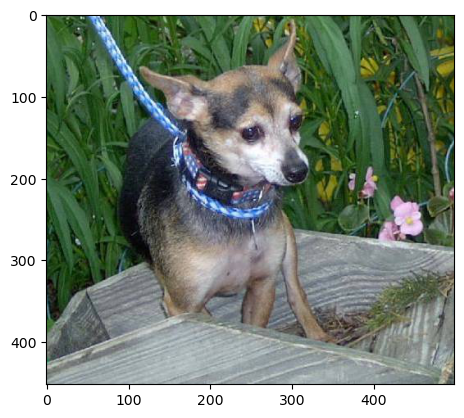

In [30]:
imagem = 'dogs/dog.4372.jpg'
classificar_imagem(imagem)

Previsão: 0


'cats'

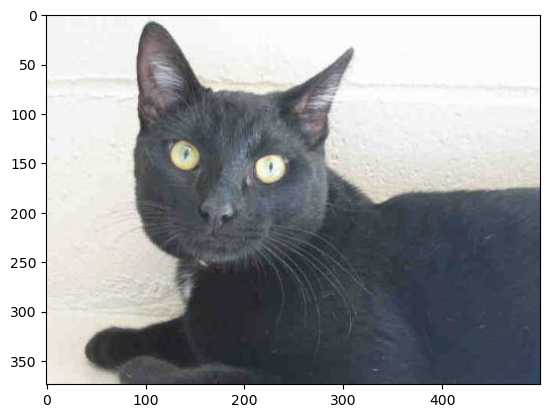

In [31]:
imagem = 'cats/cat.4388.jpg'
classificar_imagem(imagem)